Google cloud storage has much more capacity then a local "persistent" disk attached to a google cloud instance. Data stored in GCS is also permanent and can be accessed from any computer. If performing reductions of a very large dataset, it would be better to access the data directly from the cloud. Xarray provides tools for this.

This notebook demonstrates how to read a zarr file stored in the google cloud bucket.

In [1]:
%cd /home/noahb/fv3net

/home/noahb/fv3net


In [2]:
import intake
import xarray as xr

Here is a list of the data in the bucket 'vcm-ml-data':

In [3]:
ds = xr.open_zarr("data/interim/2019-07-17-FV3_DYAMOND_0.25deg_15minute_regrid_1degree.zarr/")

In [4]:
def reverse_dim(ds, dim='pfull'):
    return ds.isel({dim: slice(None, None, -1)})


def height_interfaces(dz: xr.DataArray, zs: xr.DataArray) -> xr.DataArray:
    """Compute the height from the surface elevation and thickness
    
    Args:
        dz: thickness of layers. assumes that top of atmosphere is index 0 in the pfull dimension
        zs: surface elevation
    
    Returns:
        height: height of the vertical levels
        
    """
    # TODO this should be at the interfaces rather than at the centers
    return dz.pipe(reverse_dim).cumsum('pfull').pipe(reverse_dim) + zs

In [5]:
def replace_esmf_coords(ds):
    return ds.assign_coords(x=ds.lon.isel(y=0), y=ds.lat.isel(x=0))\
      .drop(['lat', 'lon'])\
      .rename({'x': 'lon', 'y': 'lat'})

In [6]:
ds_new_coords = replace_esmf_coords(ds)

In [7]:
ds_new_coords

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, pfull: 79, time: 4)
Coordinates:
  * pfull    (pfull) float32 4.5137978 8.300872 12.451992 ... 994.3374 998.2764
  * time     (time) object 2016-08-01 03:00:00 ... 2016-08-01 12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    dp       (time, pfull, lat, lon) float64 dask.array<shape=(4, 79, 180, 360), chunksize=(1, 79, 180, 360)>
    dz       (time, pfull, lat, lon) float64 dask.array<shape=(4, 79, 180, 360), chunksize=(1, 79, 180, 360)>
    pres     (time, pfull, lat, lon) float64 dask.array<shape=(4, 79, 180, 360), chunksize=(1, 79, 180, 360)>
    qi       (time, pfull, lat, lon) float64 dask.array<shape=(4, 79, 180, 360), chunksize=(1, 79, 180, 360)>
    ql       (time, pfull, lat, lon) float64 dask.array<shape=(4, 79, 180, 360), chunksize=(1, 79, 180, 360)>
    qr       (time, pfull, lat, lon) floa

In [13]:
from src.data.advect import advection_fixed_height, apparent_source

In [9]:
qv_advection = advection_fixed_height(ds_new_coords, 'qv')

In [10]:
net_precitation = (-(qv_advection * ds_new_coords.dp/9.81).sum('pfull')*86400).persist()


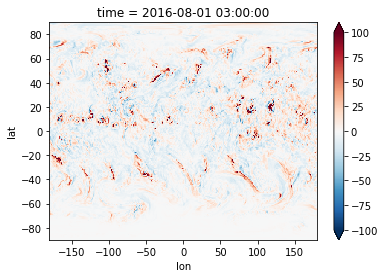

In [11]:
net_precitation[0].plot(vmax=100)